# Data Modeling

## Build machine learning models to CLASSIFY offer sending as appropriate or not. 
### We have divided the data into three classes: 
### 1) Offers that do not end into tranactions (label 0).
### 2) Offers that do not end into transaction (label 1). 
### 3) Tranasactions without offer (label 2).


In [167]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import fbeta_score, accuracy_score
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import quantile_transform, scale, robust_scale
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from keras.optimizers import Adam
import keras
from sklearn.svm import SVC
import timeit
%matplotlib inline

### Load Data

In [32]:
#load pickle
merged_df = pd.read_pickle('merged_data.pkl')

In [33]:
merged_df.head(10)

,customer_id,time,event,offer_id,label,reward,difficulty,offer_duration_hrs,bogo,discount,...,became_member_on,income,F,M,N,O,income_group,age_group,offer_type,gender
0,0009655768c64bdeb2e877511632db8f,168,offer received,5a8bc65990b245e5a138643cd4eb9837,2,0,0,72,0,0,...,1492732800000000000,72000.000000,0,1,0,0,2.0,1.0,informational,M
1,0009655768c64bdeb2e877511632db8f,336,offer received,3f207df678b143eea3cee63160fa8bed,2,0,0,96,0,0,...,1492732800000000000,72000.000000,0,1,0,0,2.0,1.0,informational,M
2,0009655768c64bdeb2e877511632db8f,408,offer received,f19421c1d4aa40978ebb69ca19b0e20d,0,5,5,120,1,0,...,1492732800000000000,72000.000000,0,1,0,0,2.0,1.0,bogo,M
3,0009655768c64bdeb2e877511632db8f,504,offer received,fafdcd668e3743c1bb461111dcafc2a4,0,2,10,240,0,1,...,1492732800000000000,72000.000000,0,1,0,0,2.0,1.0,discount,M
4,0009655768c64bdeb2e877511632db8f,576,offer received,2906b810c7d4411798c6938adc9daaa5,1,2,10,168,0,1,...,1492732800000000000,72000.000000,0,1,0,0,2.0,1.0,discount,M
5,00116118485d4dfda04fdbaba9a87b5c,168,offer received,f19421c1d4aa40978ebb69ca19b0e20d,0,5,5,120,1,0,...,1524614400000000000,65404.991568,0,0,1,0,2.0,3.0,bogo,N
6,00116118485d4dfda04fdbaba9a87b5c,576,offer received,f19421c1d4aa40978ebb69ca19b0e20d,0,5,5,120,1,0,...,1524614400000000000,65404.991568,0,0,1,0,2.0,3.0,bogo,N
7,0011e0d4e6b944f998e987f904e8c1e5,0,offer received,3f207df678b143eea3cee63160fa8bed,0,0,0,96,0,0,...,1515456000000000000,57000.000000,0,0,0,1,1.0,2.0,informational,O
8,0011e0d4e6b944f998e987f904e8c1e5,168,offer received,2298d6c36e964ae4a3e7e9706d1fb8c2,1,3,7,168,0,1,...,1515456000000000000,57000.000000,0,0,0,1,1.0,2.0,discount,O
9,0011e0d4e6b944f998e987f904e8c1e5,336,offer received,5a8bc65990b245e5a138643cd4eb9837,0,0,0,72,0,0,...,1515456000000000000,57000.000000,0,0,0,1,1.0,2.0,informational,O


### Check Columns

In [34]:
merged_df.columns

Index(['customer_id', 'time', 'event', 'offer_id', 'label', 'reward',
       'difficulty', 'offer_duration_hrs', 'bogo', 'discount', 'informational',
       'mobile', 'social', 'web', 'age', 'became_member_on', 'income', 'F',
       'M', 'N', 'O', 'income_group', 'age_group', 'offer_type', 'gender'],
      dtype='object')

### Plot the correlation matrix

In [35]:
merged_df.corr().abs().round(2)

,time,label,reward,difficulty,offer_duration_hrs,bogo,discount,informational,mobile,social,web,age,became_member_on,income,F,M,N,O,income_group,age_group
time,1.00,0.05,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
label,0.05,1.00,0.26,0.08,0.06,0.24,0.03,0.26,0.12,0.20,0.02,0.12,0.15,0.04,0.04,0.04,0.13,0.01,0.05,0.10
reward,0.00,0.26,1.00,0.47,0.16,0.79,0.29,0.62,0.08,0.29,0.12,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
difficulty,0.00,0.08,0.47,1.00,0.81,0.03,0.60,0.70,0.74,0.16,0.24,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01
offer_duration_hrs,0.00,0.06,0.16,0.81,1.00,0.18,0.74,0.68,0.53,0.19,0.34,0.01,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.01
bogo,0.00,0.24,0.79,0.03,0.18,1.00,0.67,0.41,0.27,0.25,0.10,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
discount,0.00,0.03,0.29,0.60,0.74,0.67,1.00,0.41,0.41,0.17,0.41,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01
informational,0.00,0.26,0.62,0.70,0.68,0.41,0.41,1.00,0.17,0.10,0.37,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
mobile,0.00,0.12,0.08,0.74,0.53,0.27,0.41,0.17,1.00,0.41,0.17,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.01,0.00
social,0.00,0.20,0.29,0.16,0.19,0.25,0.17,0.10,0.41,1.00,0.41,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


### We can see the age and age_group features correlated with other features in a same way. We ignore age and consider only age_group. 

In [36]:
'''Features to feed the model'''
features = [
    'reward', 'difficulty', 'offer_duration_hrs',                      # offer characteristics
    'bogo', 'discount', 'informational',                               # offer type
    'mobile', 'social', 'web',                                         # channels
    'age_group','became_member_on', 'income',  'income_group',         # customer data
    'F', 'M','N', 'O'                                                  # customer gender
]

### Scale Features

In [37]:
'''Scale features'''
scaler = MinMaxScaler()
numerical_cols = ['reward','difficulty','offer_duration_hrs','income','became_member_on']
merged_df[numerical_cols] = scaler.fit_transform(merged_df[numerical_cols])

In [38]:
merged_df.sample(10)

,customer_id,time,event,offer_id,label,reward,difficulty,offer_duration_hrs,bogo,discount,...,became_member_on,income,F,M,N,O,income_group,age_group,offer_type,gender
61502,cda2f964e6464b619519ee02445bb652,408,offer received,3f207df678b143eea3cee63160fa8bed,2,0.0,0.00,0.142857,0,0,...,0.878223,0.266667,0,1,0,0,1.0,1.0,informational,M
31008,68275bf750654990bf5e7479aed56241,408,offer received,f19421c1d4aa40978ebb69ca19b0e20d,1,0.5,0.25,0.285714,1,0,...,0.604498,0.455556,1,0,0,0,2.0,1.0,bogo,F
12606,2c38043147564d189ca3ae755b835851,0,offer received,2906b810c7d4411798c6938adc9daaa5,0,0.2,0.50,0.571429,0,1,...,0.713110,0.866667,1,0,0,0,3.0,2.0,discount,F
26824,5a3d291f75984396b6eb2800206ec716,168,offer received,fafdcd668e3743c1bb461111dcafc2a4,1,0.2,0.50,1.000000,0,1,...,0.890839,0.466667,0,1,0,0,2.0,3.0,discount,M
18355,3dace629913c4771809eea9c48bdc1ec,0,offer received,4d5c57ea9a6940dd891ad53e9dbe8da0,0,1.0,0.50,0.285714,1,0,...,0.081733,0.388889,0,1,0,0,2.0,2.0,bogo,M
59768,c7b1c663f55f405d9acb0dd1099530b0,0,offer received,2298d6c36e964ae4a3e7e9706d1fb8c2,0,0.3,0.35,0.571429,0,1,...,0.963796,0.200000,1,0,0,0,1.0,2.0,discount,F
35016,75d093ff36594695b4b7ca45e04233e6,168,offer received,2298d6c36e964ae4a3e7e9706d1fb8c2,1,0.3,0.35,0.571429,0,1,...,0.313769,0.100000,1,0,0,0,1.0,1.0,discount,F
39741,852944650a6c453f8f638807b5185b37,336,offer received,4d5c57ea9a6940dd891ad53e9dbe8da0,0,1.0,0.50,0.285714,1,0,...,0.057049,0.400000,0,1,0,0,2.0,2.0,bogo,M
5376,12779c18e3ff4c42ba1f30973d9d4009,168,offer received,2298d6c36e964ae4a3e7e9706d1fb8c2,0,0.3,0.35,0.571429,0,1,...,0.752057,0.393389,0,0,1,0,2.0,3.0,discount,N
27727,5d24f240be6a451896e2a82a824f2a1a,0,offer received,fafdcd668e3743c1bb461111dcafc2a4,1,0.2,0.50,1.000000,0,1,...,0.503017,0.400000,0,1,0,0,2.0,2.0,discount,M


### Split train and test data sets

In [41]:
data_features=merged_df[features]
data_label=merged_df['label']

### Splitting 70% of data sets into training and 30% into testing

In [62]:
X_train, X_test, y_train, y_test = train_test_split(data_features, data_label, test_size = 0.3, random_state = 42)

print("Size of Training set: {}".format(X_train.shape[0]))
print("Size of Testing set: {}".format(X_test.shape[0]))

Size of Training set: 53393
Size of Testing set: 22884


### We will try several models and consider model accuracy score as the metric to evaluate the model quality.

## 1. Neural Network
### This model will be the benchmark model to compare other classidication methods.

In [110]:
# Convert labels to "one-hot" vectors using the to_categorical function
y_train_hot = keras.utils.to_categorical(y_train, num_classes)
y_test_hot = keras.utils.to_categorical(y_test, num_classes)
print("First 5 training lables as one-hot encoded vectors:\n", y_train_hot[:5])

First 5 training lables as one-hot encoded vectors:
 [[0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [111]:
# Checking the dimensions of X_train and y_train
X_train.shape, y_train_hot.shape

((53393, 17), (53393, 3))

### Train Neural Network

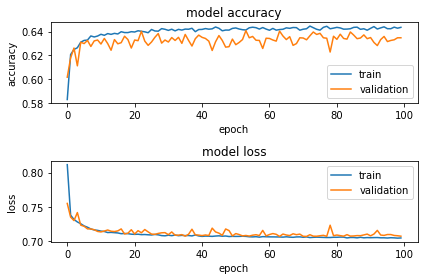

Train accuracy: 0.643
Test accuracy: 0.644
Training Time (sec.):  25.62448001800294


In [112]:
#Train Neural Network
input_dim = 17   # 17 features
num_classes = 3  # 3 labels

'''create model'''
model = Sequential()
model.add(Dense(20, input_dim=input_dim, activation='relu'))
for i in range(2): #2: Hidden layers
    model.add(Dense(10, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))  #3: Output dims
'''Compile model'''
adam_opt = Adam(lr=0.001)
model.compile(optimizer=adam_opt, loss='categorical_crossentropy', metrics=['acc'])
'''Train model'''
start = timeit.default_timer()
n_epochs= 100
n_batch= 100
history = model.fit(X_train, y_train_hot, batch_size=n_batch, epochs=n_epochs, verbose=False, validation_split=.1)
loss, accuracy  = model.evaluate(X_test, y_test_hot, verbose=False)
loss_train, accuracy_train  = model.evaluate(X_train, y_train_hot, verbose=False)

''' plotting the metrics'''
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
#
plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.tight_layout()
plt.savefig('loss.png')
plt.show()
#
#print(f'Test loss: {loss:.3}')
print(f'Train accuracy: {accuracy_train:.3}')
print(f'Test accuracy: {accuracy:.3}')
stop = timeit.default_timer()
print('Training Time (sec.): ', stop - start)



In [114]:
#Define function to predict accuracy from a model classifier
def predict_acc(model_clf):
    '''
    Calculate accuracy for the models
    Arguments:
        model classifier (model_clf)
    Returns:
        train and test accuracy
    '''
    #train and predic train and test set
    pred_train =  (model_clf.fit(X_train, y_train)).predict(X_train)
    pred_test = (model_clf.fit(X_train, y_train)).predict(X_test)
    #calculate accuracy for train and test set
    acc_train = accuracy_score(y_train, pred_train)
    acc_test = accuracy_score(y_test, pred_test)
    
    return acc_train, acc_test


## 2. Decision Tree Classifier

In [178]:
clf_dt = DecisionTreeClassifier()
acc_train_dt, acc_test_dt= predict_acc(clf_dt)
print(f'Train accuracy: {acc_train_dt:.3}')
print(f'Test accuracy: {acc_test_dt:.3}')

Train accuracy: 0.946
Test accuracy: 0.577


## 3. K-Nearest Neighbors

In [116]:
clf_knn = KNeighborsClassifier(n_neighbors = 10)
acc_train_knn, acc_test_knn= predict_acc(clf_knn)
print(f'Train accuracy: {acc_train_knn:.3}')
print(f'Test accuracy: {acc_test_knn:.3}')

Train accuracy: 0.688
Test accuracy: 0.615


## 4. Random Forest

In [104]:
clf_rf = RandomForestClassifier(random_state = 10)
acc_train_rf, acc_test_rf= predict_acc(clf_rf)
print(f'Train accuracy: {acc_train_rf:.3}')
print(f'Test accuracy: {acc_test_rf:.3}')

Train accuracy: 0.946
Test accuracy: 0.598


## 5. Support Vector Machine

In [106]:
clf_svm = SVC(gamma = 'auto')
acc_train_svm, acc_test_svm= predict_acc(clf_svm)
print(f'Train accuracy: {acc_train_svm:.3}')
print(f'Test accuracy: {acc_test_svm:.3}')

Train accuracy: 0.609
Test accuracy: 0.614


## Model Evaluation

In [158]:
data = {'Model': ['Neural Network','Decision Tree', 'K-Nearest Neighbor' , 'Random Forest', 'Support Vector Machine'], 
          'Train accuracy ':[accuracy_train, acc_train_dt, acc_train_knn, acc_train_rf,acc_train_svm], 
          'Test accuracy': [accuracy , acc_test_dt, acc_test_knn,acc_test_rf, acc_test_svm] }
compare = pd.DataFrame(data)

In [159]:
compare

,Model,Train accuracy,Test accuracy
0,Neural Network,0.642818,0.644206
1,Decision Tree,0.946435,0.577696
2,K-Nearest Neighbor,0.688218,0.614753
3,Random Forest,0.946435,0.597579
4,Support Vector Machine,0.609031,0.613922


### Out of five models, I would consider Random Forest  and K-Nearest Neighbor for further refinement. Random Forest has above 94% of train accuracy and above 59% test accuracy. This means the model is behaving not  in a similar way for the training and testing sets. On the other hand, K-Nearest Neighbor has above 68% train accuracy and above 61% test accuracy, which are almost similar.


# Refinement

### Let's use GridSearchCV to refine the hyperparameters for Random Forest and K-Nearest Neighbor

In [165]:
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
print(clf_rf.get_params())

Parameters currently in use:

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 10, 'verbose': 0, 'warm_start': False}


In [173]:
# Grid for hyper parameters
n_estimators = [100, 300, 500]
max_depth = [5, 8, 15, 25]
min_samples_split = [5, 10, 50]
min_samples_leaf = [1, 5, 10]

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

gridF = GridSearchCV(clf_rf, hyperF, cv = 3, verbose = 1, 
                      n_jobs = -1)
clf_best_rf = gridF.fit(X_train, y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  3.6min
/Users/anup/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed:  8.1min finished


### Best parameters after GridSearchCV

In [213]:
print('Best fit parameters:\n')
print(clf_best_rf.best_estimator_)

Best fit parameters:

RandomForestClassifier(max_depth=8, min_samples_leaf=10, min_samples_split=50,
                       random_state=10)


### Predicting train and test accuracy for best parameters

In [196]:
best_random= clf_best_rf.best_estimator_
pred_train_best= best_random.predict(X_train)
pred_test_best= best_random.predict(X_test)

acc_train_best_rf = accuracy_score(y_train, pred_train_best)
acc_test_best_rf = accuracy_score(y_test, pred_test_best)

print(f'Train accuracy: {acc_train_best_rf:.3}')
print(f'Test accuracy: {acc_test_best_rf:.3}')

Train accuracy: 0.654
Test accuracy: 0.647


### Searching best parameters for K-Nearest Neighbor

In [206]:
#K-Nearest Neighbor
# Look at parameters 
print('Parameters currently in use:\n')
print(clf_knn.get_params())

Parameters currently in use:

{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 10, 'p': 2, 'weights': 'uniform'}


In [212]:
grid_params= {
    'n_neighbors':[1,3,5,11,19],
    'weights': ['uniform','distance'],
    'metric': ['minkowski','euclidean','manhattan']
    }
gs_cv = GridSearchCV(clf_knn, grid_params, verbose=1, cv=3)
clf_best_knn= gs_cv.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  2.7min finished


### Best parameters after GridSearchCV

In [215]:
clf_best_knn.best_params_

{'metric': 'minkowski', 'n_neighbors': 19, 'weights': 'uniform'}

### Predicting train and test accuracy for the best parameters

In [211]:
best_knn= clf_best_knn
pred_train_best_knn = best_knn.predict(X_train)
pred_test_best_knn = best_knn.predict(X_test)

acc_train_best_knn = accuracy_score(y_train, pred_train_best_knn)
acc_test_best_knn = accuracy_score(y_test, pred_test_best_knn)

print(f'Train accuracy: {acc_train_best_knn:.3}')
print(f'Test accuracy: {acc_test_best_knn:.3}')

Train accuracy: 0.73
Test accuracy: 0.608


## Conclusion: 
### After the hyperparameter tuning, Random Forest can be taken as the best classifier because it does well on both Train and Test data sets. The test accuracy (~65%) for the given data sets and proposed problem seems to be resonable.

### Cheking the Random Forest model behavior to a customer

In [216]:
# Take any customer  from test set (unseen)
X_test[2:3]

,reward,difficulty,offer_duration_hrs,bogo,discount,informational,mobile,social,web,age_group,became_member_on,income,income_group,F,M,N,O
35235,0.2,0.5,0.571429,0,1,0,1.0,0.0,1.0,2.0,0.804717,0.5,2.0,1,0,0,0


### customer id of a test set

In [217]:
cid=merged_df.iloc[35235]['customer_id']

### Using Random Forest to predict 

In [218]:
pred_cid = clf_best_rf.predict(X_test[2:3])

In [219]:
pred_cid

array([1])

### The prediction is 1, which means the customer has chance of completing the offer to transaction. Let's check the details of the customer from original trnascript data.

In [220]:
transcript_org = pd.read_json('data/transcript.json', orient='records', lines=True)

In [221]:
transcript_org[transcript_org['person']==cid]

,person,event,value,time
1110,7668305685624445b135d38c43344985,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
49844,7668305685624445b135d38c43344985,offer viewed,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},144
49845,7668305685624445b135d38c43344985,transaction,{'amount': 23.73},144
49846,7668305685624445b135d38c43344985,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,144
54274,7668305685624445b135d38c43344985,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},168
94183,7668305685624445b135d38c43344985,offer viewed,{'offer id': '3f207df678b143eea3cee63160fa8bed'},246
140237,7668305685624445b135d38c43344985,transaction,{'amount': 10.71},372
154896,7668305685624445b135d38c43344985,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},408
195686,7668305685624445b135d38c43344985,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},480
195687,7668305685624445b135d38c43344985,transaction,{'amount': 14.04},480


### This customer completes most of the offers. In other words, this customer makes use of the offer sent. It's worth for the company to send offer to such customer.